In [91]:
%matplotlib inline
import pandas as pd
import numpy as np
import string
import sqlite3
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from scipy.stats import ttest_ind
nltk.download('stopwords')
from textblob import TextBlob
from newspaper import Article
import matplotlib
import statsmodels.api as sm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\geeki_000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
conn=sqlite3.connect('database.sqlite')


games=pd.read_sql('select * from BoardGames',conn)



In [3]:
games.columns=games.columns.str.strip().str.lower().str.replace('.','_')
list(games.columns)


['row_names',
 'game_id',
 'game_type',
 'details_description',
 'details_image',
 'details_maxplayers',
 'details_maxplaytime',
 'details_minage',
 'details_minplayers',
 'details_minplaytime',
 'details_name',
 'details_playingtime',
 'details_thumbnail',
 'details_yearpublished',
 'attributes_boardgameartist',
 'attributes_boardgamecategory',
 'attributes_boardgamecompilation',
 'attributes_boardgamedesigner',
 'attributes_boardgameexpansion',
 'attributes_boardgamefamily',
 'attributes_boardgameimplementation',
 'attributes_boardgameintegration',
 'attributes_boardgamemechanic',
 'attributes_boardgamepublisher',
 'attributes_total',
 'stats_average',
 'stats_averageweight',
 'stats_bayesaverage',
 'stats_family_abstracts_bayesaverage',
 'stats_family_abstracts_pos',
 'stats_family_cgs_bayesaverage',
 'stats_family_cgs_pos',
 'stats_family_childrensgames_bayesaverage',
 'stats_family_childrensgames_pos',
 'stats_family_familygames_bayesaverage',
 'stats_family_familygames_pos',
 'st

Text(0, 0.5, 'Count')

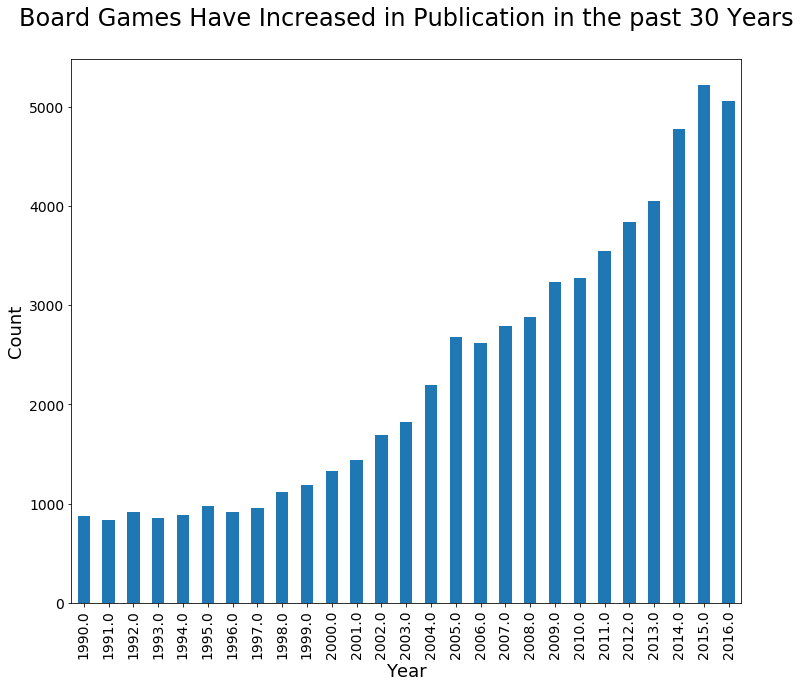

In [6]:
years=list(range(1990, 2017))
Games=games[games.details_yearpublished.isin(years)].reset_index()
Games['details_yearpublished'].value_counts()

ax = Games['details_yearpublished'].value_counts().sort_index().plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('Board Games Have Increased in Publication in the past 30 Years\n',fontsize=24)
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('Count',fontsize=18)

In [7]:
def clean_text(article):
    clean1 = re.sub(r'['+string.punctuation + '’—”'+']', "", article.lower())
    return re.sub(r'\W+', ' ', clean1)

Games['tokenized'] = Games['details_description'].map(lambda x: clean_text(x))


In [8]:
Games['tokenized'].head()

0    part of the knizia tilelaying trilogy samurai ...
1    when you see the triangular box and the luxuri...
2    in this interesting offering from warfrog play...
3    although referred to as a sequel to el grande ...
4    elfenland is a redesign of the original white ...
Name: tokenized, dtype: object

In [9]:
Games['numwords'] = Games['tokenized'].apply(lambda x: len(x.split()))
CleanDesc = Games[Games['numwords']>0].reset_index()


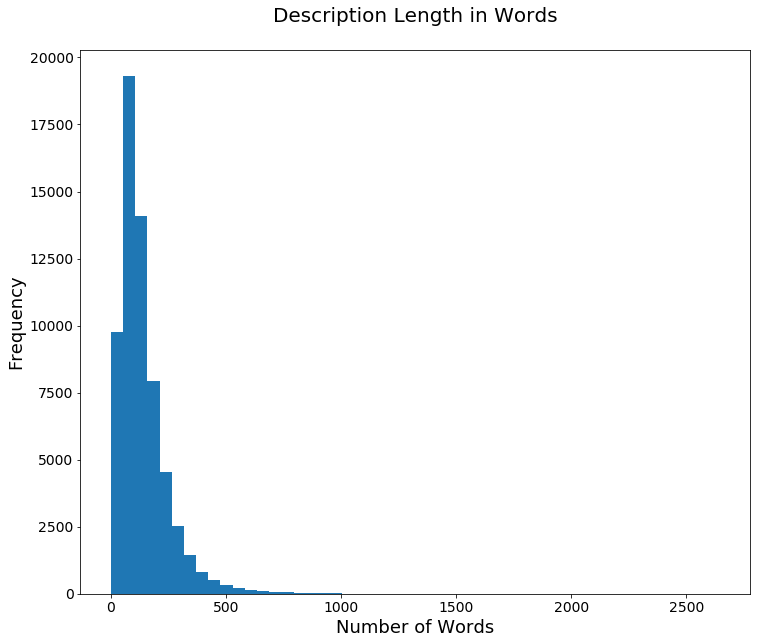

In [10]:
ax=CleanDesc['numwords'].plot(kind='hist', bins=50, fontsize=14, figsize=(12,10))
ax.set_title('Description Length in Words\n', fontsize=20)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlabel('Number of Words', fontsize=18);

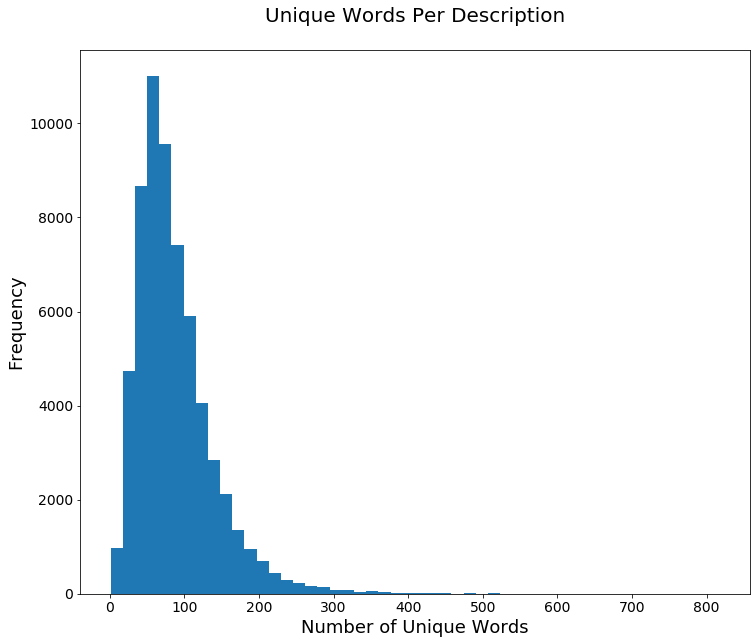

In [11]:
CleanDesc['uniq_wds'] = CleanDesc['tokenized'].str.split().apply(lambda x: len(set(x)))
CleanDesc['uniq_wds'].head()

ax=CleanDesc['uniq_wds'].plot(kind='hist', bins=50, fontsize=14, figsize=(12,10))
ax.set_title('Unique Words Per Description\n', fontsize=20)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlabel('Number of Unique Words', fontsize=18);

In [12]:
wd_counts = Counter()
for i, row in CleanDesc.iterrows():
    wd_counts.update(row['tokenized'].split())
    
for sw in stopwords.words('english'):
    del wd_counts[sw]

In [13]:
def find_cc_wds(content, cc_wds=['campaign','legacy',"story","narrative"]
):
    found = False
    for w in cc_wds:
        if w in content:
            found = True
            break
            
    if not found:
        disj = re.compile(r'(driv\w+\W+(?:\w+\W+){1,5}?narrativ) | (narrativ\W+(?:\w+\W+){1,5}?driv)')
        if disj.match(content):
            found = True       
            
    return found

CleanDesc['leg_words']=CleanDesc['tokenized'].apply(find_cc_wds)


In [14]:
#CleanDesc['leg_words'].sum()/len(CleanDesc)

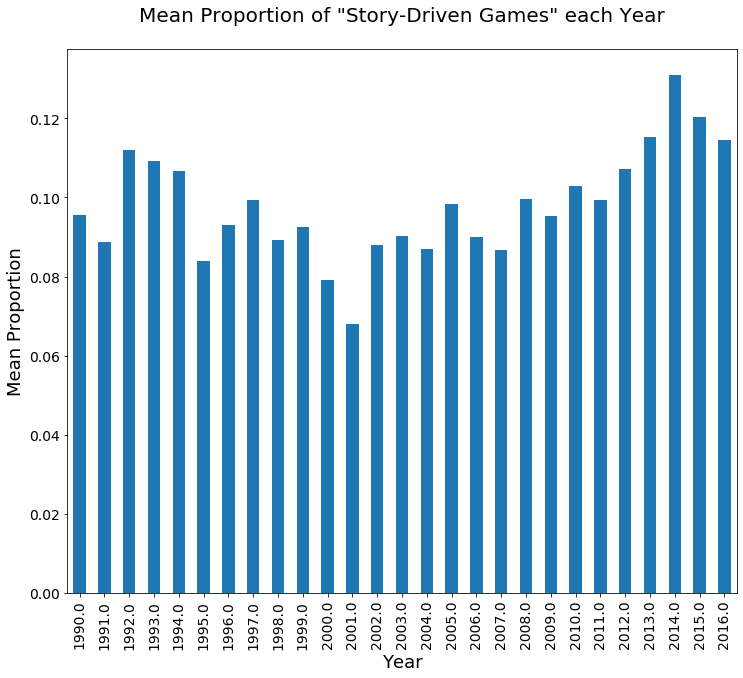

In [15]:
game_years = CleanDesc.groupby('details_yearpublished')

proportions = game_years['leg_words'].sum() / game_years['leg_words'].count()
proportions.sort_values(ascending=True)
ax=proportions.plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('Mean Proportion of "Story-Driven Games" each Year\n', fontsize=20)
ax.set_ylabel('Mean Proportion', fontsize=18)
ax.set_xlabel('Year', fontsize=18);




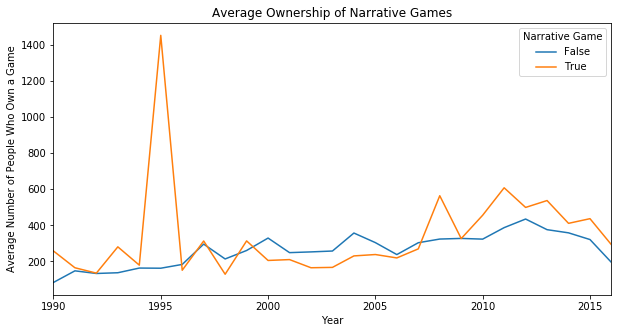

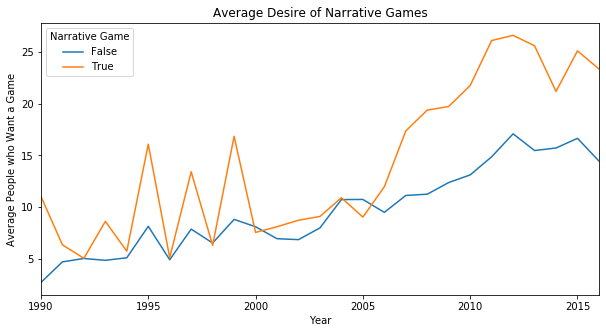

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
grouped_multiple = CleanDesc.groupby(['details_yearpublished', 'leg_words']).mean()['stats_owned'].unstack().plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Average Number of People Who Own a Game')
ax.set_title('Average Ownership of Narrative Games')
ax.legend(title='Narrative Game')

fig, ax = plt.subplots(figsize=(10,5))
grouped_multiple = CleanDesc.groupby(['details_yearpublished', 'leg_words']).mean()['stats_wanting'].unstack().plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Average People who Want a Game')
ax.set_title('Average Desire of Narrative Games')
ax.legend(title='Narrative Game')



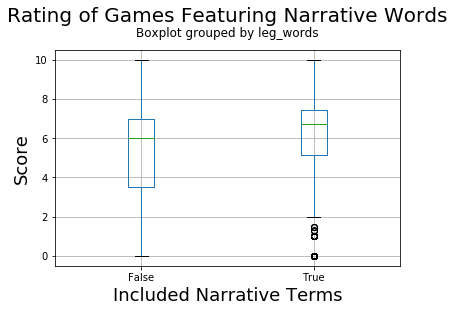

In [16]:
story_games=CleanDesc.groupby('leg_words')

years2=list(range(2005, 2017))
bx=CleanDesc[CleanDesc.details_yearpublished.isin(years2)].boxplot(column='stats_average',by='leg_words')
bx.set_title('Rating of Games Featuring Narrative Words\n', fontsize=20)
bx.set_ylabel('Score', fontsize=18)
bx.set_xlabel('Included Narrative Terms', fontsize=18);

In [17]:
#CleanDesc[CleanDesc.details_yearpublished.isin(years2)].boxplot(column='stats_wanting',by='leg_words')

In [18]:
#CleanDesc[CleanDesc.details_yearpublished.isin(years2)].boxplot(column='stats_wishing',by='leg_words')

In [19]:
def standard_err(p1, n1, p2, n2):
    return np.sqrt((p1* (1-p1) / n1) + (p2 * (1-p2) / n2))

def ci_range(diff, std_err, cv=1.96):
    return (diff - cv * std_err, diff + cv * std_err)

def calc_ci_range(p1, n1, p2, n2):
    std_err = standard_err(p1, n1, p2, n2)
    diff = p1-p2
    return ci_range(diff, std_err)

story = story_games.get_group(True)
nostory = story_games.get_group(False)

ttest_ind(story.stats_average,nostory.stats_average)


Ttest_indResult(statistic=21.558409638063075, pvalue=1.0547143790004381e-102)

In [20]:
test_desc=TextBlob(CleanDesc.details_description[100])
test_desc.sentiment.polarity

polarity=[]

for row in CleanDesc['details_description']:
    desc_blob=TextBlob(row)
    polarity.append(desc_blob.sentiment.polarity)
    


In [21]:
CleanDesc['senti']=polarity

In [22]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


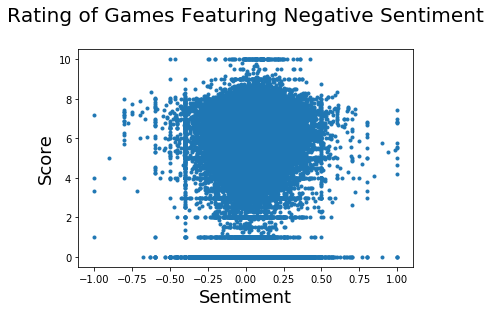

In [23]:
X = CleanDesc['senti'].values.reshape(-1, 1)  
Y = CleanDesc['stats_average'].values.reshape(-1, 1)  
linear_regressor = LinearRegression() 
linear_regressor.fit(X, Y)  
Y_pred = linear_regressor.predict(X)  


plt.scatter(X, Y, marker=".")
#plt.plot(X, Y_pred, color='red')
plt.title('Rating of Games Featuring Negative Sentiment\n', fontsize=20)
plt.ylabel('Score', fontsize=18)
plt.xlabel('Sentiment', fontsize=18);
plt.show()

In [24]:
def find_fear_wds(content, cc_wds=['horror','horrified','horrific','hellish','grenade','tragic','anguish','abomination','abandon','alien','beware','scary','frightening','afraid','conspire','corrupt']
):
    found = False
    for w in cc_wds:
        if w in content:
            found = True
            break
            

    return found

CleanDesc['fear_words']=CleanDesc['tokenized'].apply(find_fear_wds)

Ttest_indResult(statistic=21.558409638063075, pvalue=1.0547143790004381e-102)

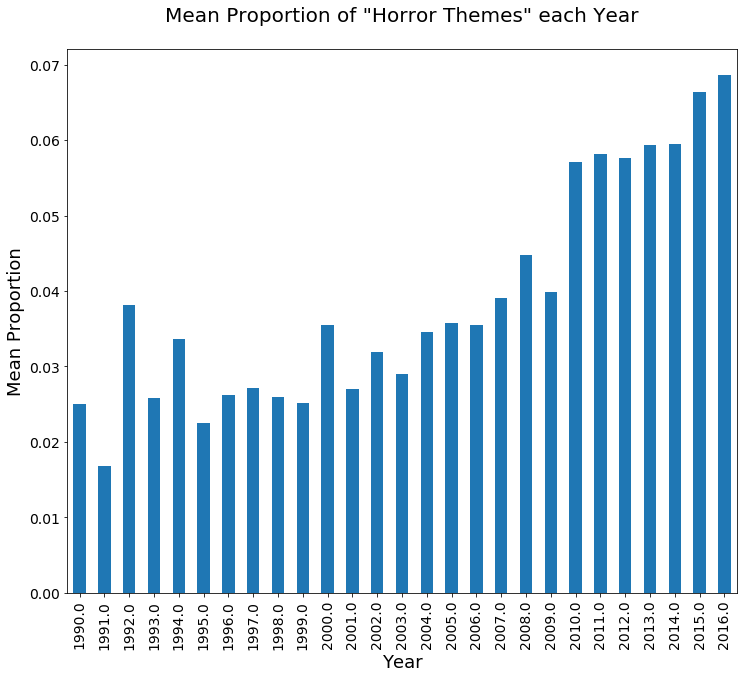

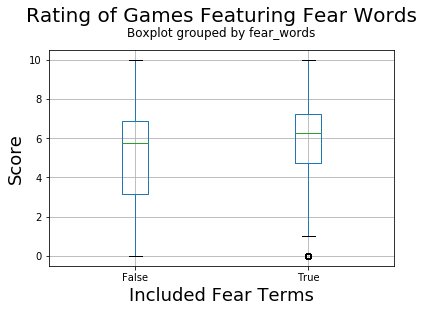

In [25]:
game_years2 = CleanDesc.groupby('details_yearpublished')

proportions = game_years2['fear_words'].sum() / game_years['fear_words'].count()
proportions.sort_values(ascending=True)
ax=proportions.plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('Mean Proportion of "Horror Themes" each Year\n', fontsize=20)
ax.set_ylabel('Mean Proportion', fontsize=18)
ax.set_xlabel('Year', fontsize=18);


scary_games=CleanDesc.groupby('leg_words')
bx=CleanDesc.boxplot(column='stats_average',by='fear_words')
bx.set_title('Rating of Games Featuring Fear Words\n', fontsize=20)
bx.set_ylabel('Score', fontsize=18)
bx.set_xlabel('Included Fear Terms', fontsize=18);

scary = scary_games.get_group(True)
notscary = scary_games.get_group(False)

ttest_ind(scary.stats_average,notscary.stats_average)


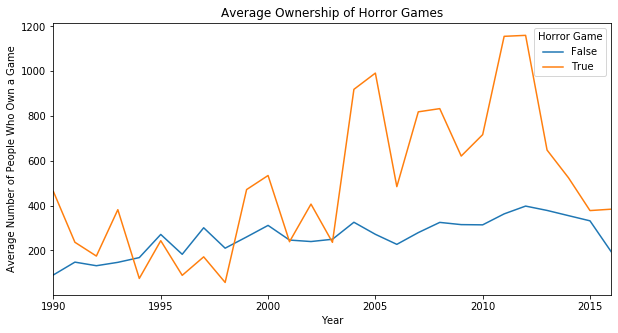

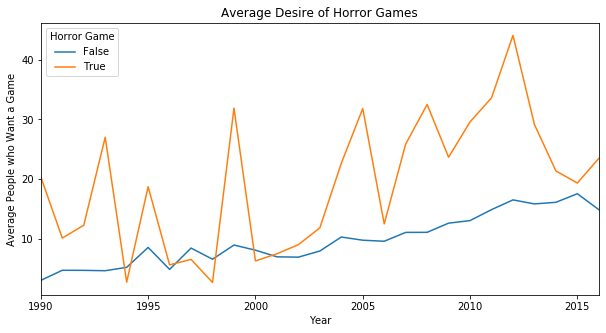

In [69]:
fig, ax = plt.subplots(figsize=(10,5))
grouped_multiple = CleanDesc.groupby(['details_yearpublished', 'fear_words']).mean()['stats_owned'].unstack().plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Average Number of People Who Own a Game')
ax.set_title('Average Ownership of Horror Games')
ax.legend(title='Horror Game')

fig, ax = plt.subplots(figsize=(10,5))
grouped_multiple = CleanDesc.groupby(['details_yearpublished', 'fear_words']).mean()['stats_wanting'].unstack().plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Average People who Want a Game')
ax.set_title('Average Desire of Horror Games')
ax.legend(title='Horror Game')
